# Hermite polynomial interpolation

Hermite polynomial interpolation allows us to construct a polynomial that not only passes through a set of given data points but also matches the derivative (slope) at each of those points. This is particularly useful in engineering when we have information about the rate of change of a quantity, in addition to its value.

The general problem can be stated as follows:

Given $n$ data points $(x_1, u_1), (x_2, u_2), \ldots, (x_n, u_n)$ and $n$ corresponding first derivative values $u'_1, u'_2, \ldots, u'_n$ at these points, we want to find a polynomial $u(x)$ of degree $2n-1$ such that:
$u(x_i) = u_i$ and $u'(x_i) = u'_i$ for $i=1, \ldots, n$.

The Hermite interpolating polynomial is given by:
$$
u(x) = \sum_{i=1}^n P_i(x) u_i + \sum_{i=1}^n Q_i(x) u'_i
$$

where $P_i(x)$ and $Q_i(x)$ are polynomials of degree $2n-1$ defined as:
\begin{align*}
P_i(x) &= \left(1 - 2L'_i(x_i)(x - x_i)\right)L_i^2(x) &
Q_i(x) &= (x - x_i)L_i^2(x)
\end{align*}
and $L_i(x)$ is the $i$-th Lagrange basis polynomial:
$$
L_i(x) = \prod_{\substack{j=1 \\ j \neq i}}^n \frac{x - x_j}{x_i - x_j}
$$

The term $L'_i(x_i)$ represents the derivative of the $i$-th Lagrange basis polynomial evaluated at the point $x_i$, which can be calculated as:
$$
L'_i(x_i) = \frac{\operatorname{d}\! L_i(x_i)}{\operatorname{d}\! x}= \sum_{\substack{k=1 \\ k \neq i}}^n \frac{1}{x_i - x_k}
$$

## Derivation of the derivative of the Lagrange basis polynomial
To derive this last result we start from the equation of the Lagrange polynomial,
$$
L_i(x) = \prod_{\substack{j=1 \\ j \neq i}}^n \frac{x - x_j}{x_i - x_j}
$$
we take the natural logarithm at both sides:
$$
\ln\Big(L_{i}(x)\Big)
= \ln\bigg(\prod_{\substack{j=1 \\ j \neq i}}^n \frac{x-x_{j}}{x_{i}-x_{j}}  \bigg)
= \sum_{\substack{j=1 \\ j \neq i}}^n \ln\left( \frac{x-x_{j}}{x_{i}-x_{j}} \right)
$$
Now, taking the derivative on both sides, and using the result $\frac{\operatorname{d}\!}{\operatorname{d}\!x}\ln f(x) = \frac{1}{f(x)} \frac{\operatorname{d}\!f(x)}{\operatorname{d}\!x}$, we obtain:
$$
\frac{L'_i(x)}{L_i(x)} =\sum_{\substack{j=1 \\ j \neq i}}^n \frac{\frac{1}{x_i-x_j}}{\frac{x-x_j}{x_i-x_j}} = \sum_{\substack{j=1 \\ j \neq i}}^n \frac{1}{x-x_j}
$$
that is,
$$
L'_i(x) = L_i(x) \Big( \sum_{\substack{j=1 \\ j \neq i}}^n \frac{1}{x-x_j}  \Big)
$$   

Let's implement this and explore a couple of ways to achieve Hermite interpolation using SciPy.

---

## Setup
First, let's import the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import KroghInterpolator, BarycentricInterpolator

---
## Method 1: Hermite Interpolation from Scratch

We'll implement the formulas provided step-by-step.

### Lagrange Basis Polynomials
First, we need the Lagrange basis polynomials $L_i(x)$ and their derivatives at the nodes $L'_i(x_i)$.

The $i$-th Lagrange basis polynomial $L_i(x)$ is:
$$
L_i(x) = \prod_{\substack{j=1 \\ j \neq i}}^n \frac{x - x_j}{x_i - x_j}
$$

In [2]:
def L(x, i, x_nodes):
    """
    Computes the i-th Lagrange basis polynomial L_i(x) at point x.
    """
    n = len(x_nodes)
    if not (0 <= i < n):
        raise ValueError("Index i out of bounds for x_nodes.")

    prod = 1.0
    for j in range(n):
        if i == j:
            continue
        if x_nodes[i] == x_nodes[j]: # Should not happen for distinct nodes
            raise ValueError("x_nodes must be distinct for Lagrange basis polynomials.")
        prod *= (x - x_nodes[j])/(x_nodes[i] - x_nodes[j])
    return prod

The derivative of the $i$-th Lagrange basis polynomial evaluated at the point $x_i$ is:
$$
L'_i(x_i) = \frac{\operatorname{d}\! L_i(x_i)}{\operatorname{d}\! x}= \sum_{\substack{k=1 \\ k \neq i}}^n \frac{1}{x_i - x_k}
$$

In [3]:
def dL_dx(i, x_nodes):
    """
    Computes the derivative of the i-th Lagrange basis polynomial L'_i(x_i) at node x_i.
    """
    n = len(x_nodes)
    if not (0 <= i < n):
        raise ValueError("Index i out of bounds for x_nodes.")

    sum_val = 0.0
    for k in range(n):
        if i == k:
            continue
        if x_nodes[i] == x_nodes[k]:
            raise ValueError("x_nodes must be distinct.")
        sum_val += 1.0/(x_nodes[i] - x_nodes[k])
    return sum_val

### Hermite basis polynomials
Now, we define the Hermite basis polynomials $P_i(x)$ and $Q_i(x)$:
\begin{align*}
P_i(x) &= \left(1 - 2L'_i(x_i)(x - x_i)\right)L_i^2(x) &
Q_i(x) &= (x - x_i)L_i^2(x)
\end{align*}

In [4]:
def P_herm(x, i, x_nodes):
    """
    Computes the Hermite basis polynomial P_i(x).
    """
    Li_x   = L(x, i, x_nodes)
    dLi_xi = dL_dx(i, x_nodes)
    return (1 - 2*dLi_xi*(x - x_nodes[i]))*Li_x**2

def Q_herm(x, i, x_nodes):
    """
    Computes the Hermite basis polynomial Q_i(x).
    """
    Li_x = L(x, i, x_nodes)
    return (x - x_nodes[i])*Li_x**2

### Full Hermite Interpolation Polynomial
Finally, we combine these to form the Hermite interpolating polynomial $u(x)$:
$$
u(x) = \sum_{i=1}^n P_i(x) u_i + \sum_{i=1}^n Q_i(x) u'_i
$$

In [5]:
def hermite_interpolation_scratch(x_eval_points, x_nodes, u_nodes, du_nodes):
    """
    Computes the Hermite interpolating polynomial at points x_eval_points.

    Args:
        x_eval_points: A single point or a NumPy array of points to evaluate the polynomial.
        x_nodes:  NumPy array of n distinct data point x-coordinates.
        u_nodes:  NumPy array of n function values u_i at x_nodes.
        du_nodes: NumPy array of n derivative values u'_i at x_nodes.

    Returns:
        Interpolated value(s) at x_eval_points.
    """
    n = len(x_nodes)
    if len(u_nodes) != n or len(du_nodes) != n:
        raise ValueError("Input arrays x_nodes, u_nodes, du_nodes must have the same length.")

    # Ensure x_eval_points is an array for consistency
    if isinstance(x_eval_points, (int, float)):
        x_eval_arr = np.array([x_eval_points], dtype=float)
    else:
        x_eval_arr = np.asarray(x_eval_points, dtype=float)

    u_interp_values = np.zeros_like(x_eval_arr)

    for idx, x in enumerate(x_eval_arr):
        u_sum = 0.0
        for i in range(n):
            u_sum += P_herm(x, i, x_nodes)*u_nodes[i]
            u_sum += Q_herm(x, i, x_nodes)*du_nodes[i]
        u_interp_values[idx] = u_sum

    # Return a scalar if a single point was passed, otherwise the array
    if isinstance(x_eval_points, (int, float)):
        return u_interp_values[0]
    else:
        return u_interp_values

---
## Method 2: SciPy's `KroghInterpolator`

SciPy provides `KroghInterpolator`, which can handle derivative information directly, making it suitable for Hermite interpolation. When initializing `KroghInterpolator`, you can provide the function values and their derivatives at each point.

If `x_nodes` are the points $x_i$, and `y_data` is structured as `[[u_1, u'_1, u''_1, ...], [u_2, u'_2, u''_2, ...], ...]`, then `KroghInterpolator(x_nodes, y_data)` will compute the interpolating polynomial. For our case, where we only have $u_i$ and $u'_i$, `y_data` will be a list or array of pairs `[u_i, u'_i]`.

## Comparison of Methods

Let's define a set of data points and derivatives, then interpolate using all three methods and plot the results.

### Test Data
We'll use a sample function to generate our data points and derivatives.
Let
$$f(x) = x \cos(x) + \sin(x^2/2).$$
Then
$$f'(x) = \cos(x) - x \sin(x) + x \cos(x^2/2).$$

In [6]:
f     = lambda x : x * np.cos(x) + np.sin(x**2 / 2)
df_dx = lambda x : np.cos(x) - x * np.sin(x) + x * np.cos(x**2 / 2)

# Define nodes, values, and derivatives
x_nodes  = np.linspace(0, 4.5, 5) # 5 points for a degree 2*5-1 = 9 polynomial
u_nodes  = f(x_nodes)
du_nodes = df_dx(x_nodes)

print("x_nodes:               ", x_nodes)
print("u_nodes  (f(x_nodes)): ", u_nodes)
print("du_nodes (f'(x_nodes)):", du_nodes)

# Points for evaluation and plotting
x      = np.linspace(min(x_nodes) - 0.5, max(x_nodes) + 0.5, 500)
y_true = f(x) # True function for comparison

x_nodes:                [0.    1.125 2.25  3.375 4.5  ]
u_nodes  (f(x_nodes)):  [ 0.          1.07648858 -0.84024237 -3.83807551 -1.59296859]
du_nodes (f'(x_nodes)): [ 1.          0.32328874 -4.22260458  2.61614538  0.74694366]


### Interpolation Calculations

In [7]:
# Method 1: Scratch Implementation
y_scratch = hermite_interpolation_scratch(x, x_nodes, u_nodes, du_nodes)

# Method 2: SciPy's KroghInterpolator
# For KroghInterpolator, y_data is an array of [value, 1st_derivative, 2nd_derivative, ...]
# So we stack u_nodes and du_nodes column-wise.
x_nodes_krogh = np.c_[x_nodes, x_nodes ].flatten()
y_nodes_krogh = np.c_[u_nodes, du_nodes].flatten()
krogh_interpolator = KroghInterpolator(x_nodes_krogh, y_nodes_krogh)
y_krogh = krogh_interpolator(x)

### Plotting the Results
Let's visualize the interpolations and compare them. We'll also plot the original data points and indicate their specified slopes.

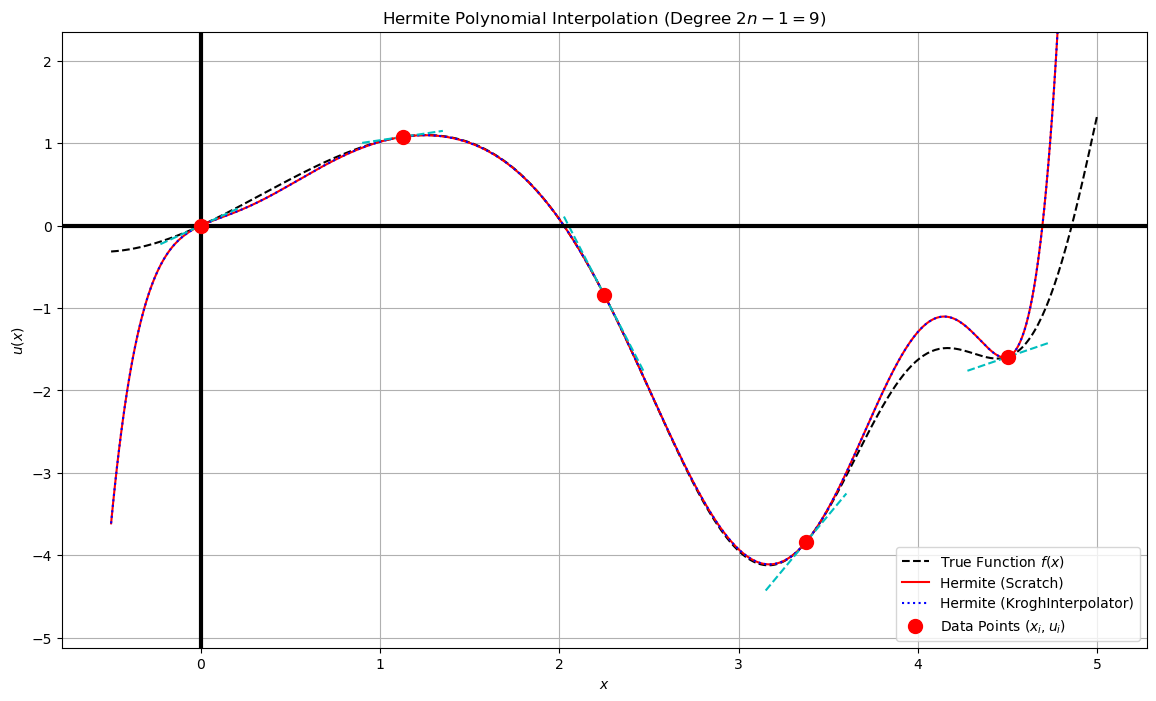

In [8]:
plt.figure(figsize=(14, 8))

# Plot the true function (if known, for comparison)
plt.plot(x, y_true, 'k--', label='True Function $f(x)$')

# Plot results from each method
plt.plot(x, y_scratch, 'r-', label='Hermite (Scratch)')
plt.plot(x, y_krogh,   'b:', label='Hermite (KroghInterpolator)')

# Plot the known data points
plt.plot(x_nodes, u_nodes, 'ro', label='Data Points $(x_i, u_i)$', markersize=10, zorder=5)

# Plot slope indicators at each data point
# dx_slope should be small relative to the scale of x-axis
plot_range_x = max(x_nodes) - min(x_nodes)
if plot_range_x == 0: # Handle case of single data point if it ever occurs
    dx_slope = 0.1
else:
    dx_slope = plot_range_x/20 # Adjust for better visualization

# Plot red dashed lines for slopes
for i in range(len(x_nodes)):
    x_i, u_i, du_i = x_nodes[i], u_nodes[i], du_nodes[i]
    plt.plot([x_i - dx_slope, x_i + dx_slope],
             [u_i - dx_slope*du_i, u_i + dx_slope*du_i],
             'c--', linewidth=1.5, label='_nolegend_')

plt.title(f'Hermite Polynomial Interpolation (Degree $2n-1 = {2*len(x_nodes)-1}$)')
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.legend(loc='best')
plt.grid(True)
plt.ylim([min(y_true) - 1, max(y_true) + 1])
plt.axhline(0, color='black',linewidth=3)
plt.axvline(0, color='black',linewidth=3)
plt.show()


### Verifying the algorithms

In [9]:
# Print differences to check how close they are
print("\nMax absolute difference (Scratch vs Krogh):", np.max(np.abs(y_scratch - y_krogh)))

# Check if interpolated polynomials pass through points and match derivatives (for scratch and Krogh)
print("\nChecking constraints for Scratch implementation:")
for i in range(len(x_nodes)):
    u_at_node_i = hermite_interpolation_scratch(x_nodes[i], x_nodes, u_nodes, du_nodes)
    print(f"  Node x_{i}={x_nodes[i]:.3f}:  u({x_nodes[i]:.3f})={u_at_node_i: .5f} (Expected: {u_nodes[i]: .5f})")

print("\nChecking constraints for KroghInterpolator:")
for i in range(len(x_nodes)):
    u_at_node_i = krogh_interpolator(x_nodes[i])
    print(f"  Node x_{i}={x_nodes[i]:.3f}:  u({x_nodes[i]:.3f})={u_at_node_i: .5f} (Expected: {u_nodes[i]: .5f})")

print("\nLet's check the derivatives:")
for i in range(len(x_nodes)):
    du_at_node_i = krogh_interpolator.derivative(x_nodes[i])
    print(f"  Node x_{i}={x_nodes[i]:.3f}: u'({x_nodes[i]:.3f})={du_at_node_i: .5f} (Expected: {du_nodes[i]: .5f})")


Max absolute difference (Scratch vs Krogh): 5.1514348342607263e-14

Checking constraints for Scratch implementation:
  Node x_0=0.000:  u(0.000)= 0.00000 (Expected:  0.00000)
  Node x_1=1.125:  u(1.125)= 1.07649 (Expected:  1.07649)
  Node x_2=2.250:  u(2.250)=-0.84024 (Expected: -0.84024)
  Node x_3=3.375:  u(3.375)=-3.83808 (Expected: -3.83808)
  Node x_4=4.500:  u(4.500)=-1.59297 (Expected: -1.59297)

Checking constraints for KroghInterpolator:
  Node x_0=0.000:  u(0.000)= 0.00000 (Expected:  0.00000)
  Node x_1=1.125:  u(1.125)= 1.07649 (Expected:  1.07649)
  Node x_2=2.250:  u(2.250)=-0.84024 (Expected: -0.84024)
  Node x_3=3.375:  u(3.375)=-3.83808 (Expected: -3.83808)
  Node x_4=4.500:  u(4.500)=-1.59297 (Expected: -1.59297)

Let's check the derivatives:
  Node x_0=0.000: u'(0.000)= 1.00000 (Expected:  1.00000)
  Node x_1=1.125: u'(1.125)= 0.32329 (Expected:  0.32329)
  Node x_2=2.250: u'(2.250)=-4.22260 (Expected: -4.22260)
  Node x_3=3.375: u'(3.375)= 2.61615 (Expected:  2.61

This notebook provides a comprehensive look at Hermite polynomial interpolation, from theory and manual implementation to using SciPy's powerful tools. The comparison plot should illustrate that, when implemented correctly, the scratch method and `KroghInterpolator` yield identical results, as they are both exact Hermite interpolators. Pay attention to the degree of the resulting polynomial, which is $2n-1$. With more points, the polynomial degree increases, which can lead to oscillations (Runge's phenomenon) between nodes, especially near the edges of the interpolation interval.